In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

Dataset creation

In [2]:
df = pd.read_parquet(r"C:\Users\adrie\OneDrive\Documents\EPFL\ML\Project 2\All_Relative_Results_Cleaned.parquet")

In [3]:
df.head(3)

,Participant,Exercise,Set,Camera,time(s),left_ankle_x,left_ankle_y,left_ankle_z,left_ear_x,left_ear_y,...,right_pinky_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_thumb_x,right_thumb_y,right_thumb_z,right_wrist_x,right_wrist_y,right_wrist_z
0,P04,Abduction,Correct,Frontal_Top,0.000,0.009328,0.779305,0.187880,0.020658,-0.693419,...,-0.633111,-0.054347,-0.511760,-0.185118,-0.068159,-0.602015,-0.598093,-0.066565,-0.600690,-0.592768
1,P04,Abduction,Correct,Frontal_Top,0.033,0.009353,0.779298,0.185050,0.021187,-0.693361,...,-0.630835,-0.054293,-0.511703,-0.184861,-0.068130,-0.602200,-0.596219,-0.066508,-0.600835,-0.590916
2,P04,Abduction,Correct,Frontal_Top,0.067,0.009722,0.779311,0.179212,0.021351,-0.693388,...,-0.630923,-0.054289,-0.511696,-0.184849,-0.067241,-0.601852,-0.596222,-0.065676,-0.600436,-0.590910


In [4]:
df['Camera'].unique()

array(['Frontal_Top', 'Frontal_Low', 'Side_Top'], dtype=object)

In [3]:
df_clean = df.dropna()
index = df_clean.columns.get_loc('time(s)')
df_right = df_clean.iloc[:, index+1:]
X = df_right
Y = df_clean['Exercise']

In [4]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [5]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(Y_encoded, dtype=torch.long)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TensorDataset(X_train,Y_train)
test_dataset = TensorDataset(X_test,Y_test)
trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=32 , shuffle=True)

**Neural network architecture**

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64,128)
        self.layer3 = nn.Linear(128,256)
        self.layer4 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        return x

model = NeuralNetwork()

**Training configuration**

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Model training**

In [27]:
model.train()

for epoch in range(10):  # 4 is the nbr of epochs
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for inputs, labels in trainLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculer la perte moyenne et l'exactitude pour l'époque
    epoch_loss = running_loss / len(trainLoader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Époque {epoch + 1}, Perte: {epoch_loss:.4f}, Exactitude: {epoch_accuracy:.2f}%')


Époque 1, Perte: 0.1742, Exactitude: 92.68%
Époque 2, Perte: 0.1421, Exactitude: 93.93%
Époque 3, Perte: 0.1322, Exactitude: 94.37%
Époque 4, Perte: 0.1262, Exactitude: 94.66%
Époque 5, Perte: 0.1227, Exactitude: 94.85%
Époque 6, Perte: 0.1203, Exactitude: 94.97%
Époque 7, Perte: 0.1190, Exactitude: 95.05%
Époque 8, Perte: 0.1179, Exactitude: 95.12%
Époque 9, Perte: 0.1170, Exactitude: 95.17%
Époque 10, Perte: 0.1162, Exactitude: 95.23%


**Model testing**

In [28]:
model.eval()  # Mettre le modèle en mode évaluation
total_test = 0
correct_test = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testLoader:
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Exactitude sur l\'ensemble de test: {test_accuracy}%')


Exactitude sur l'ensemble de test: 94.8273097888324%


**Confusion matrix visualization**

Text(52.722222222222214, 0.5, 'True labels')

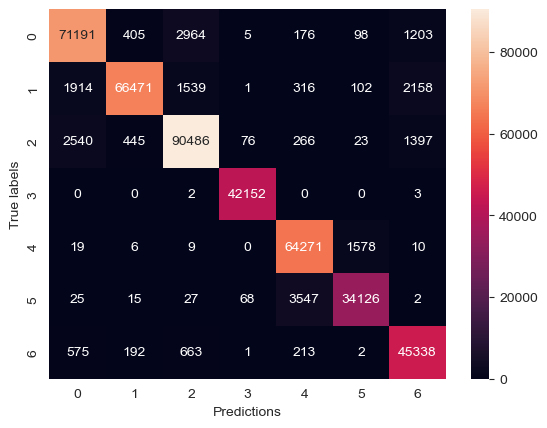

In [29]:
conf_matrix = confusion_matrix(y_true,y_pred)

sns.heatmap(conf_matrix, annot=True, fmt = 'd')
plt.xlabel('Predictions')
plt.ylabel('True labels')

**Classification report**

In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     76042
           1       0.98      0.92      0.95     72501
           2       0.95      0.95      0.95     95233
           3       1.00      1.00      1.00     42157
           4       0.93      0.98      0.95     65893
           5       0.95      0.90      0.93     37810
           6       0.90      0.96      0.93     46984

    accuracy                           0.95    436620
   macro avg       0.95      0.95      0.95    436620
weighted avg       0.95      0.95      0.95    436620


**Convolutionnal Neural network**

Data preprocessing

In [41]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3,1,1), stride=1, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(1,1,1), stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3968, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

modelCNN = ConvNeuralNetwork()

CNN config

In [42]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(modelCNN.parameters(), lr = 0.001)

In [43]:
scheduler_cnn = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

Training Cnn

In [54]:

cols_x = [col for col in X.columns if col.endswith('x')]
cols_y = [col for col in X.columns if col.endswith('y')]
cols_z = [col for col in X.columns if col.endswith('z')]
tensor_5D = torch.zeros((len(X), 3, 33, 1, 1), dtype=torch.float32)


In [32]:
nbr_of_points = (X.shape[1])//3
X_reshape = X.values.reshape(-1,nbr_of_points,3)
tensor_4D_transposed = np.expand_dims(np.expand_dims(np.transpose(X_reshape, (0, 2, 1)), axis=3), axis=4)
tensor_5D = torch.from_numpy(tensor_4D_transposed)
tensor_5D = tensor_5D.permute(0, 2, 1, 3, 4)
print(tensor_5D.shape)
original_x = X[cols_x[1]].iloc[0]
original_y = X[cols_y[1]].iloc[0]
original_z = X[cols_z[1]].iloc[0]

print( tensor_5D[0, 1,:, 0, 0])
print("Original:", original_x, original_y, original_z)

torch.Size([2183099, 33, 3, 1, 1])
tensor([ 0.0207, -0.6934,  0.0230])
Original: 0.020658314 -0.6934193 0.023042714


In [67]:
mean_coords = pd.DataFrame()
mean_coords['x_mean'] = X[cols_x].mean(axis = 1)
mean_coords['y_mean'] = X[cols_y].mean(axis = 1)
mean_coords['z_mean'] = X[cols_z].mean(axis = 1)

In [88]:
from sklearn.decomposition import PCA

# Utiliser PCA pour réduire à trois dimensions
pca = PCA(n_components=3)
reduced_coords = pca.fit_transform(mean_coords)

# Normaliser les coordonnées réduites pour qu'elles correspondent à votre grille 3D
# Par exemple, si votre grille est de taille 3x3x11
normalized_coords = (reduced_coords - reduced_coords.min(0)) / reduced_coords.ptp(0)
print(normalized_coords.shape)
grid_coords = np.round(normalized_coords * np.array([2, 2, 10])).astype(int)


(2183099, 3)


In [89]:
unique_coords, counts = np.unique(grid_coords, axis=0, return_counts=True)

# Identifier les coordonnées où plus d'une feature a été mappée
duplicate_coords = unique_coords[counts > 1]
print("Coordonnées avec des doublons :", duplicate_coords)

Coordonnées avec des doublons : [[ 0  0  4]
 [ 0  0  5]
 [ 0  0  6]
 [ 0  0  7]
 [ 0  1  1]
 [ 0  1  2]
 [ 0  1  3]
 [ 0  1  4]
 [ 0  1  5]
 [ 0  1  6]
 [ 0  1  7]
 [ 0  1  8]
 [ 0  2  3]
 [ 0  2  4]
 [ 0  2  5]
 [ 0  2  6]
 [ 1  0  1]
 [ 1  0  2]
 [ 1  0  3]
 [ 1  0  4]
 [ 1  0  5]
 [ 1  0  6]
 [ 1  0  7]
 [ 1  1  0]
 [ 1  1  1]
 [ 1  1  2]
 [ 1  1  3]
 [ 1  1  4]
 [ 1  1  5]
 [ 1  1  6]
 [ 1  1  7]
 [ 1  1  8]
 [ 1  1  9]
 [ 1  1 10]
 [ 1  2  1]
 [ 1  2  2]
 [ 1  2  3]
 [ 1  2  4]
 [ 1  2  5]
 [ 1  2  6]
 [ 1  2  7]
 [ 1  2  8]
 [ 2  0  2]
 [ 2  0  3]
 [ 2  0  4]
 [ 2  0  5]
 [ 2  0  6]
 [ 2  1  1]
 [ 2  1  2]
 [ 2  1  3]
 [ 2  1  4]
 [ 2  1  5]
 [ 2  1  6]
 [ 2  1  7]
 [ 2  1  8]
 [ 2  2  2]
 [ 2  2  3]
 [ 2  2  4]
 [ 2  2  5]
 [ 2  2  6]
 [ 2  2  7]
 [ 2  2  8]]


In [91]:
duplicate_coords.shape

(62, 3)

In [90]:
for coord in duplicate_coords:
    # Trouver les indices des features qui ont été mappées à ces coordonnées
    features_at_coord = np.where((grid_coords == coord).all(axis=1))[0]
    print(f"Features mappées à {coord} : {features_at_coord}")


Features mappées à [0 0 4] : [  46564   46569   46570   47044   47046   47064   47065   47067   47068
   47070   49063   49064   49065   49067   49068   50891   50892   50893
   50894  121936  121937 1213785 1219517 1219518 1219519 1385861 1385865
 1385866 1385867 1385868 1385869 1385870 1385871 1385872 1385873 1385874
 1385875 1385876 1385877 1385878 1385879 1385880 1385881 1385882 1385883
 1385884 1385885 1385886 1385887 1385889 1385890 1385891 1385892 1385893
 1393744 1393752 1393756 1393759 1393764 1393767 1440900 1494463 1631875
 1634340 1634341 1637605 1984628 1984629 1984630 1984631 1984632 1984633
 1984634]
Features mappées à [0 0 5] : [  47034   47035   47036   47037   47038   47039   47040   47041   47042
   47043   47045   47054   47055   47058   47059   49059   49060   49061
   49062   50890   50897 1623709 1631874 1631876 1631877 1632704 1637607
 1637618 1637619]
Features mappées à [0 0 6] : [ 341046 1542539 1635977 1635978 1637610 1637611 1637617]
Features mappées à [0 0 

In [92]:
feature_to_grid = {}
for feature_idx, coord in enumerate(grid_coords):
    coord_tuple = tuple(coord)
    if coord_tuple not in feature_to_grid:
        feature_to_grid[coord_tuple] = []
    feature_to_grid[coord_tuple].append(feature_idx)

# Identifier les coordonnées avec des doublons
for coord, features in feature_to_grid.items():
    if len(features) > 1:
        print(f"Coordonnées {coord} ont les features {features}")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [72]:
depth, height, width = 3, 3, 11

# Nombre de canaux (supposons 3 pour x, y, z)
num_channels = 3

# Nombre d'échantillons
num_samples = 2183099

# Initialiser un tenseur vide
grid_tensor = torch.zeros((num_samples, num_channels, depth, height, width))

In [73]:
# Parcourir chaque feature et placer ses valeurs dans le tenseur
for feature_idx in range(33):  # Supposons que vous avez 33 features
    # Coordonnées normalisées et arrondies pour la feature actuelle
    d, h, w = grid_coords[feature_idx]

    # Assurer que les indices sont dans les limites de la grille
    d, h, w = np.clip([d, h, w], 0, [depth - 1, height - 1, width - 1])

    # Placer les valeurs de la feature dans le tenseur
    # Ici, cols_x, cols_y, cols_z sont les noms des colonnes dans X pour chaque coordonnée
    grid_tensor[:, 0, d, h, w] = torch.tensor(X[cols_x[feature_idx]].values)
    grid_tensor[:, 1, d, h, w] = torch.tensor(X[cols_y[feature_idx]].values)
    grid_tensor[:, 2, d, h, w] = torch.tensor(X[cols_z[feature_idx]].values)


In [79]:
for feature_idx in range(5):  # Vérifier les 5 premières features
    d, h, w = grid_coords[feature_idx]
    print(f"Feature {feature_idx}: Coordonnées dans la grille - Profondeur: {d}, Hauteur: {h}, Largeur: {w}")

sample_idx = 0  # Index d'un échantillon
d, h, w = 1, 1, 4  # Choisissez une position spécifique dans la grille
print(grid_tensor[sample_idx, :, d, h, w])  # Affiche les valeurs x, y, z à cette position


Feature 0: Coordonnées dans la grille - Profondeur: 1, Hauteur: 1, Largeur: 4
Feature 1: Coordonnées dans la grille - Profondeur: 1, Hauteur: 1, Largeur: 4
Feature 2: Coordonnées dans la grille - Profondeur: 1, Hauteur: 1, Largeur: 4
Feature 3: Coordonnées dans la grille - Profondeur: 1, Hauteur: 1, Largeur: 4
Feature 4: Coordonnées dans la grille - Profondeur: 1, Hauteur: 1, Largeur: 4
tensor([-0.0666, -0.6007, -0.5928])


In [85]:
print(grid_coords.shape)

(2183099, 3)


In [80]:
# Coordonnées normalisées et arrondies pour la première feature
d, h, w = grid_coords[0]
print(f"Coordonnées normalisées et arrondies de la première feature : Profondeur: {d}, Hauteur: {h}, Largeur: {w}")


Coordonnées normalisées et arrondies de la première feature : Profondeur: 1, Hauteur: 1, Largeur: 4


In [81]:
# Assurez-vous que les indices sont dans les limites de la grille
d, h, w = np.clip([d, h, w], 0, [depth - 1, height - 1, width - 1])

# Récupérer les valeurs de la première feature dans le tenseur
feature_values = grid_tensor[:, :, d, h, w]
print(f"Valeurs de la première feature dans le tenseur : {feature_values}")


Valeurs de la première feature dans le tenseur : tensor([[-0.0666, -0.6007, -0.5928],
        [-0.0665, -0.6008, -0.5909],
        [-0.0657, -0.6004, -0.5909],
        ...,
        [-0.6179, -0.5307, -0.1396],
        [-0.6172, -0.5295, -0.1397],
        [-0.6170, -0.5290, -0.1410]])


In [82]:
# Valeurs originales de la première feature dans X
original_values = X.iloc[:, :3]  # Supposant que les 3 premières colonnes sont x, y, z de la première feature
print(f"Valeurs originales de la première feature dans X : {original_values.head()}")


Valeurs originales de la première feature dans X :    left_ankle_x  left_ankle_y  left_ankle_z
0      0.009328      0.779305      0.187880
1      0.009353      0.779298      0.185050
2      0.009722      0.779311      0.179212
3      0.011696      0.778027      0.166566
4      0.011671      0.778045      0.166878


In [77]:
grid_tensor.shape 

torch.Size([2183099, 3, 3, 3, 11])

In [35]:
Y_tensor_cnn = y_tensor
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(tensor_5D, Y_tensor_cnn, test_size=0.2)
X_train_cnn = X_train_cnn.permute(0, 2, 1, 3, 4)

print(X_train_cnn.shape)
dataset_train_cnn = TensorDataset(X_train_cnn, Y_train_cnn)
trainLoader_cnn = DataLoader(dataset_train_cnn, batch_size=33, shuffle=True)
dataset_test_cnn = TensorDataset(X_test_cnn, Y_test_cnn)
testLoader_cnn = DataLoader(dataset_test_cnn, batch_size=32, shuffle=True)

torch.Size([1746479, 3, 33, 1, 1])


In [45]:
num_epochs = 4  # ou le nombre d'époques souhaité
modelCNN.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for inputs, labels in trainLoader_cnn:
        optimizer_cnn.zero_grad()            
        outputs = modelCNN(inputs)          
        loss = criterion_cnn(outputs, labels)  
        loss.backward()                    
        optimizer_cnn.step()
        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        if scheduler_cnn:
            scheduler_cnn.step()
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epuch {epoch + 1}/{num_epochs}, Loss : {running_loss / len(trainLoader_cnn)},  Accuracy: {epoch_accuracy:.2f}%'")


KeyboardInterrupt: 

In [6]:
def map_to_grid(x, y, z, grid_size, min_vals, max_vals):
    x_norm = (x - min_vals[0]) / (max_vals[0] - min_vals[0])
    y_norm = (y - min_vals[1]) / (max_vals[1] - min_vals[1])
    z_norm = (z - min_vals[2]) / (max_vals[2] - min_vals[2])

    x_idx = np.clip((x_norm * grid_size).astype(int), 0, grid_size - 1)
    y_idx = np.clip((y_norm * grid_size).astype(int), 0, grid_size - 1)
    z_idx = np.clip((z_norm * grid_size).astype(int), 0, grid_size - 1)


    return x_idx, y_idx, z_idx


In [8]:
print(x_idx.shape)


(2183099, 33)


In [10]:
depth, height, width = 100, 100, 100

num_features = 3
num_inputs = X.shape[0]
print(num_inputs)
grid_tensor = torch.zeros((num_inputs, depth, height, width, num_features), dtype = torch.float32)

2183099


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 26197188000000 bytes.

In [ ]:
print(grid_tensor.shape)

for i in range(2183099):  # Pour chaque enregistrement
    for j in range(33):   # Pour chaque feature
        d, h, w = x_idx[i, j], y_idx[i, j], z_idx[i, j]
        # Assurez-vous que les indices sont dans les limites de la grille
        d, h, w = np.clip([d, h, w], 0, [depth - 1, height - 1, width - 1])
        # Extraire les valeurs x, y, z pour la feature
        val_x = X[cols_x].iloc[i, j]
        val_y = X[cols_y].iloc[i, j]
        val_z = X[cols_z].iloc[i, j]
        # Placer les valeurs dans le tenseur
        grid_tensor[i, d, h, w, :] = torch.tensor([val_x, val_y, val_z])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, grid_tensor, labels):
        self.grid_tensor = grid_tensor
        self.labels = labels

    def __len__(self):
        return len(self.grid_tensor)

    def __getitem__(self, idx):
        return self.grid_tensor[idx], self.labels[idx]

# Créer une instance du dataset
dataset = CustomDataset(grid_tensor, labels)

# Créer un DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

NameError: name 'Dataset' is not defined